# Часть 4. Улучшение действующей модели

Итак, мы научились обрабатывать данные, выбрали схему кросс-валидации и определились с метриками качества. Пора переходить к оптимизации модели. На этой неделе вам предстоит принять участие в соревновании на платформе kaggle inclass! Цель такого соревнования - преодолеть предложенное baseline решение, а, главное, обсудить и сравнить предложенные решения на форуме. Какие признаки оказали наибольший вклад в модель? Как лучше обрабатывать категориальные признаки? Нужно ли делать отбор признаков, А балансировать выборку?

Данная часть работы выполняется, исходя из предварительной визуальной оценки данных, которая осуществлялась на неделе 1-3. 
Итогом этой оценки стали следующие выводы, которые будем использовать для построения модели: 
    
1. Схема кросс-валидации:StratifiedShuffleSplit
2. Тип модели: Градиентный бустинг
3. Метрики качества: ROC-AUC, accuracy, f1. 

#### Цель работы:

Разработать модель, позволяющую относить клиента телеком-оператора к одному из классов (отток / не отток) с целью проведения кампании по удержанию клиента.При разработке алгоритма учитывалась стратегия удержания клиентов, заключающаяся в рассылке смс-писем на личный номер абонента с предложением о скидке на услуги сотовой связи.

Перейдите по ссылке на страницу соревнования: https://inclass.kaggle.com/c/telecom-clients-prediction2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit, train_test_split
from sklearn.model_selection import train_test_split, cross_val_score,  StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from catboost import CatBoostClassifier, Pool, cv
from numpy.random import RandomState

from category_encoders import OrdinalEncoder, LeaveOneOutEncoder, CatBoostEncoder, TargetEncoder, WOEEncoder, JamesSteinEncoder, OneHotEncoder
import xgboost as xgb
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

## Этап 1: Загрузка данных 

In [2]:
data = pd.read_csv('orange_small_churn_data.train') # загрузим датасет
data = data.dropna(how='all', axis=1) # выбросим признаки где только пустые значения 
data = data.dropna(thresh=data.shape[0] * 0.1, axis=1) #выбросим признаки где менее 90% информации по столбцу
# axis = 1 - удаляет столбцы 

data

,Var6,Var7,Var13,Var21,Var22,Var24,Var25,Var28,Var35,Var38,...,Var219,Var220,Var221,Var222,Var223,Var225,Var226,Var227,Var228,Var229
0,3052.0,NaN,NaN,480.0,600.0,20.0,480.0,200.00,0.0,82752.0,...,FzaX,hLKtJ9p,Al6ZaUT,vr93T2a,LM8l689qOp,NaN,fKCe,02N6s8f,xwM2aC7IdeMC0,NaN
1,1813.0,7.0,636.0,212.0,265.0,2.0,128.0,166.56,0.0,2706120.0,...,FzaX,hN8KpA1,oslk,6hQ9lNX,LM8l689qOp,ELof,xb3V,RAYp,55YFVY9,mj86
2,1953.0,7.0,448.0,176.0,220.0,0.0,72.0,311.76,0.0,4698780.0,...,FzaX,4UxGlow,zCkv,catzS2D,LM8l689qOp,NaN,FSa2,ZI9m,ib5G6X1eUxUn6,mj86
3,1533.0,7.0,4.0,332.0,415.0,0.0,144.0,220.08,5.0,864384.0,...,FzaX,ylCK5YS,oslk,e4lqvY0,LM8l689qOp,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN
4,686.0,7.0,0.0,160.0,200.0,2.0,48.0,278.00,0.0,4364880.0,...,FzaX,PYpzAu9,oslk,MAz3HNj,LM8l689qOp,NaN,WqMG,RAYp,F2FyR07IdsN7I,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,938.0,7.0,28.0,156.0,195.0,2.0,24.0,290.40,0.0,6753420.0,...,FzaX,U8IVcJ1,oslk,8xSqDjb,LM8l689qOp,kG3k,FSa2,RAYp,F2FyR07IdsN7I,mj86
39996,1750.0,7.0,428.0,216.0,270.0,4.0,88.0,133.12,0.0,2197110.0,...,FzaX,5ZxD5lR,oslk,WUmqPCU,LM8l689qOp,NaN,WqMG,RAYp,F2FyR07IdsN7I,NaN
39997,1204.0,7.0,2276.0,156.0,195.0,6.0,72.0,153.20,0.0,0.0,...,FzaX,B9vNioI,oslk,pHOw_BK,LM8l689qOp,ELof,WqMG,RAYp,F2FyR07IdsN7I,am7c
39998,8232.0,14.0,788.0,1224.0,1530.0,24.0,512.0,220.08,0.0,4710966.0,...,FzaX,SCnYWu3,oslk,WC7Esaq,LM8l689qOp,NaN,wX53,RAYp,F2FyR07IdsN7I,NaN


In [3]:
labels = pd.read_csv('orange_small_churn_labels.train', header = None, names = ['target']) # метки классов 
labels = labels. replace({-1:0}) # заменим -1 на 0, чтобы улучшить вопсрпиятие данных
labels.head(5)

,target
0,0
1,0
2,0
3,1
4,0


In [4]:
# делим выборку на обучающую и тестовую в размере 80 на 20

from sklearn.model_selection import train_test_split

train_data,test_data,train_labels,test_labels = train_test_split(data,labels,shuffle=True, test_size=0.2, random_state = 17)

## Этап 2: Обработка признаков

In [5]:
# сформируем списки с вещественными и категориальными признаками по датасету без пустых полей

num_cols = data.dtypes[data.dtypes != 'object'].index
cat_cols = data.dtypes[data.dtypes == 'object'].index

In [6]:
num_cols

Index(['Var6', 'Var7', 'Var13', 'Var21', 'Var22', 'Var24', 'Var25', 'Var28',
       'Var35', 'Var38', 'Var44', 'Var57', 'Var65', 'Var72', 'Var73', 'Var74',
       'Var76', 'Var78', 'Var81', 'Var83', 'Var85', 'Var94', 'Var109',
       'Var112', 'Var113', 'Var119', 'Var123', 'Var125', 'Var126', 'Var132',
       'Var133', 'Var134', 'Var140', 'Var143', 'Var144', 'Var149', 'Var153',
       'Var160', 'Var163', 'Var173', 'Var181', 'Var189'],
      dtype='object')

In [7]:
cat_cols

Index(['Var192', 'Var193', 'Var194', 'Var195', 'Var196', 'Var197', 'Var198',
       'Var199', 'Var200', 'Var201', 'Var202', 'Var203', 'Var204', 'Var205',
       'Var206', 'Var207', 'Var208', 'Var210', 'Var211', 'Var212', 'Var214',
       'Var216', 'Var217', 'Var218', 'Var219', 'Var220', 'Var221', 'Var222',
       'Var223', 'Var225', 'Var226', 'Var227', 'Var228', 'Var229'],
      dtype='object')

- Сделаем замену пропусков категориальных признаков на редкие категории, например, "-999"

In [8]:
#заменим пропуски в категориальных на редкие категории

train_data_cat = train_data # датасет для обработки категориальных признаков
train_data_cat[cat_cols] = train_data_cat[cat_cols].fillna('-999') # замение пустоты на -999

Поскольку мы будем использовать модель градиентного бустинга и мы заменили пустые значения на уникальное значение = -999.
То можно попробовать использовать такой метод, как CatBoost.

CatBoost — библиотека для градиентного бустинга, главным преимуществом которой является то, что она одинаково хорошо работает «из коробки» как с числовыми признаками, так и с категориальными.

Градиентный бустинг — метод машинного обучения, который создает решающую модель прогнозирования в виде ансамбля слабых моделей прогнозирования, обычно деревьев решений. Он строит модель поэтапно, позволяя оптимизировать произвольную дифференцируемую функцию потерь.

In [9]:
# сделаем классификатор на основе CatBoost
clf = CatBoostClassifier(random_seed=17, eval_metric='AUC', verbose=False,
                        early_stopping_rounds=50, nan_mode='Max', loss_function='Logloss')


# eval_metric - оценивающая метрика
# early_stopping_rounds - останавливает обучение после указанного количества итераций с момента итерации с оптимальным значением метрики.
# verbose - False = отсутствие шума 
# loss_function - Метрика, используемая в обучении.
# nan_mode - Метод обработки отсутствующих значений во входном наборе данных.
# В данном случае "Max"- отсутствующие значения обрабатываются как максимальное значение (больше всех других значений) 
#для функции. Гарантируется, что при выборе деревьев учитывается разделение, которое отделяет отсутствующие значения от всех остальных значений.

In [10]:
# проведем кросс-валидацию по данному классификатору
cv_results_base = cv(Pool(train_data_cat, train_labels, cat_features=cat_cols), clf.get_params(), stratified=True,
                     early_stopping_rounds=50, seed=17, plot=False, verbose=False, shuffle=True)

# pool - это датасеты, которые используются для валидации

Stopped by overfitting detector  (50 iterations wait)


In [11]:
cv_results_base

,iterations,test-AUC-mean,test-AUC-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
0,0,0.522521,0.011675,0.661431,0.000138,0.661407,0.000150
1,1,0.554884,0.034579,0.631838,0.000320,0.631835,0.000271
2,2,0.578740,0.033854,0.604372,0.000683,0.604363,0.000634
3,3,0.593464,0.012572,0.579099,0.000845,0.579099,0.000782
4,4,0.600753,0.025138,0.555889,0.001047,0.555870,0.001018
...,...,...,...,...,...,...,...
520,520,0.749325,0.004577,0.234999,0.001088,0.209867,0.001744
521,521,0.749346,0.004593,0.234996,0.001092,0.209814,0.001764
522,522,0.749344,0.004638,0.235000,0.001096,0.209767,0.001798
523,523,0.749368,0.004634,0.234997,0.001086,0.209733,0.001796


In [12]:
print('Максимальное значение метрики AUC = ', cv_results_base['test-AUC-mean'].max())

Максимальное значение метрики AUC =  0.7495952699068673


Из части с визуальным анализом данных были выделены числовые признаки, похожие на категории. Обработаем эти признаки

In [13]:
# посмотрим на данные признаков, где количество уникальных категорий не превышает 20 
data[['Var173', 'Var143', 'Var7', 'Var181', 'Var44', 'Var72', 'Var144', 'Var35', 'Var78', 'Var65', 'Var132']].head(20)

,Var173,Var143,Var7,Var181,Var44,Var72,Var144,Var35,Var78,Var65,Var132
0,0.0,0.0,NaN,0.0,0.0,NaN,9.0,0.0,0.0,NaN,0.0
1,0.0,0.0,7.0,0.0,0.0,3.0,18.0,0.0,0.0,27.0,0.0
2,0.0,0.0,7.0,0.0,0.0,3.0,27.0,0.0,0.0,18.0,0.0
3,0.0,0.0,7.0,0.0,0.0,NaN,0.0,5.0,0.0,9.0,8.0
4,0.0,0.0,7.0,0.0,0.0,3.0,9.0,0.0,0.0,9.0,0.0
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.0,0.0,0.0,0.0,0.0,6.0,9.0,0.0,0.0,18.0,0.0
7,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,18.0,0.0
8,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,9.0,0.0
9,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,9.0,0.0


In [14]:
#добавим новые категориальные признаки

# список числовых признаков, которые будем рассматривать как категориальные 
new_cat_cols = ['Var173', 'Var143', 'Var7', 'Var181', 'Var44', 'Var72', 'Var144', 'Var35', 'Var78', 'Var65', 'Var132'] 
cat_cols_new = cat_cols.tolist()
cat_cols_new = cat_cols_new + new_cat_cols # добавляем эти признаки к старому списку категориальных признаков

# создадим новый список числовых переменных, убрат оттуда категориальные 
num_cols_new = []
for x in data.columns:
    if x not in cat_cols_new:
        num_cols_new.append(x)


In [15]:
cat_cols_new

['Var192',
 'Var193',
 'Var194',
 'Var195',
 'Var196',
 'Var197',
 'Var198',
 'Var199',
 'Var200',
 'Var201',
 'Var202',
 'Var203',
 'Var204',
 'Var205',
 'Var206',
 'Var207',
 'Var208',
 'Var210',
 'Var211',
 'Var212',
 'Var214',
 'Var216',
 'Var217',
 'Var218',
 'Var219',
 'Var220',
 'Var221',
 'Var222',
 'Var223',
 'Var225',
 'Var226',
 'Var227',
 'Var228',
 'Var229',
 'Var173',
 'Var143',
 'Var7',
 'Var181',
 'Var44',
 'Var72',
 'Var144',
 'Var35',
 'Var78',
 'Var65',
 'Var132']

In [16]:
num_cols_new

['Var6',
 'Var13',
 'Var21',
 'Var22',
 'Var24',
 'Var25',
 'Var28',
 'Var38',
 'Var57',
 'Var73',
 'Var74',
 'Var76',
 'Var81',
 'Var83',
 'Var85',
 'Var94',
 'Var109',
 'Var112',
 'Var113',
 'Var119',
 'Var123',
 'Var125',
 'Var126',
 'Var133',
 'Var134',
 'Var140',
 'Var149',
 'Var153',
 'Var160',
 'Var163',
 'Var189']

Обработаем новые категориальные признаки

In [17]:
#заменим пропуски в категориальных на редкие категории

train_data_cat[cat_cols_new] = train_data_cat[cat_cols_new].fillna('-999') # замение пустоты на -999
train_data_cat[cat_cols_new] = train_data_cat[cat_cols_new].astype(str)

In [18]:
# проведем кросс-валидацию по классификатору c новыми признаками
cv_results_new = cv(Pool(train_data_cat, train_labels, cat_features=cat_cols_new), clf.get_params(), stratified=True,
                     early_stopping_rounds=50, seed=17, plot=False, verbose=False, shuffle=True)


# pool - это датасеты, которые используются для валидации

Stopped by overfitting detector  (50 iterations wait)


In [19]:
print('Максимальное значение метрики AUC = ', cv_results_new['test-AUC-mean'].max())

Максимальное значение метрики AUC =  0.750076226497661


### Вывод:

Значение метрики AUC стало выше, что, возможно, можно свидетельствовать о повышении качества модели при использовании обработки признаков таким способом. 

## Этап 3: Отбор признаков

Будем придерживаться двух основных стратегий отбора признаков: 
1. удалим те признаки, которые дают нулевой вклад в модель.
2. попробуем найти признаки, которые понижаю качество модели и удалим их 


In [20]:
# разобьем данные на основе предыдущего пункта для построения и оценки модели
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(train_data_cat,train_labels,
                                                                    stratify=train_labels,shuffle=True, 
                                                                    test_size=0.2, random_state = 17)

In [21]:
# опишем функцию для создания классификаторакатбуста

def model_catboost(X_train_new, y_train, X_valid, y_valid):
    model = CatBoostClassifier(
    random_seed=17,
    #ускоряет расчет
    task_type='GPU',
    #ранняя остановка
    early_stopping_rounds=200,
    #считаем целевую метрику
    eval_metric='AUC')
    #обучение классификатора
    model.fit(
    X_train_new, y_train,
    cat_features=cat_cols,
    eval_set=(X_valid, y_valid),
    verbose=False)
    
    return model

In [22]:
#обучаем модель

model = model_catboost(X_train_new,y_train_new,X_test_new,y_test_new)

In [23]:
#создадим список признаков по по их вкладу в модель 
#model.get_feature_importance(Pool(X_train_new,label=y_train_new,cat_features=cat_cols)) - array коэфициенты вклада признаков в модель

feature_scores = pd.DataFrame(list(zip(X_train_new.dtypes.index, model.get_feature_importance(Pool(X_train_new,
                                                                                                 label=y_train_new,
                                                                                                 cat_features=cat_cols)))),
                             columns=['Feature_name', 'Score'])
#соритовка
feature_scores = feature_scores.sort_values(by='Score', ascending=False, inplace=False, na_position='last')

In [24]:
feature_scores 

,Feature_name,Score
28,Var126,32.492006
64,Var217,12.347306
49,Var199,7.055050
50,Var200,7.041985
62,Var214,6.615240
...,...,...
33,Var143,0.000000
34,Var144,0.000000
37,Var160,0.000000
1,Var7,0.000000


Проведем работу с признакми. Удалим те, которые имеют нулевой вклад в модель. 

In [25]:
features_to_delete = feature_scores[feature_scores['Score'] == 0.0]['Feature_name']
features_to_delete = [x for x in features_to_delete]
cat_cols = [x for x in cat_cols]
num_cols = [x for x in num_cols]

In [26]:
#удалим признаки с нулевой важностью по результатам отбора из нашего датасета
train_x_drop = train_data_cat.drop(features_to_delete, axis=1)

#определим новый набор категориальных и числовых признаков 
cat_cols_selected = train_x_drop.dtypes[train_x_drop.dtypes=='object'].index
num_cols_selected = [x for x in train_x_drop.columns if x not in cat_cols_selected]

Кросс-валидация по новому датасету

In [27]:
# проведем кросс-валидацию по классификатору c новыми признаками
cv_results_corrected  = cv(Pool(train_x_drop, train_labels, cat_features=cat_cols_selected), clf.get_params(), stratified=True,
                     early_stopping_rounds=50, seed=17, plot=False, verbose=False, shuffle=True)


# pool - это датасеты, которые используются для валидации


print('Максимальное значение метрики AUC для модели Catboost = ', cv_results_corrected['test-AUC-mean'].max())

Stopped by overfitting detector  (50 iterations wait)
Максимальное значение метрики AUC для модели Catboost =  0.7528535888409111


In [28]:
clf.get_params()

{'loss_function': 'Logloss',
 'nan_mode': 'Max',
 'random_seed': 17,
 'verbose': False,
 'eval_metric': 'AUC',
 'early_stopping_rounds': 50}

### Вывод:

Качество модели стало немного лучше. 
Займемся теперь кодированием категориальных признаков

## Этап 4: Кодирование категориальных признаков

Я использовал метод Catboost, который имеет собственный встроенный метод кодировки категориальных признаков.
Такие методы, как XGBoost или LightGBM не имеют встроенных инструментов для кодировки и признаки нужно предварительно обрабатывать при помощи кодировщиков.
Кодировщики бывают двух видов: Unsupervised (без учителя) и Supervised (с учителем). Нас интересует Supervised.


Посмотрим, можно ли другим методом градиентного бустинга добиться результатов лучше, чем тот результат, который дает модель Catboost. 

- Загружаем из модуля category_encoders кодировщики.

pip install category_encoders

import category_encoders

In [29]:
#список кодировщиков
encoder_list = [OrdinalEncoder,
                LeaveOneOutEncoder,
                CatBoostEncoder,
                TargetEncoder,
                WOEEncoder,
                JamesSteinEncoder]

# OrdinalEncoder - кодирует категориальные признаки, как целочисленный массив. Получается один столбец целых чисе
# LeaveOneOutEncoder - среднее по каждому уровню.
# CatBoostEncoder - кодер из катбуста.
# TargetEncoder- признаки заменяются смесью апостериорной вероятности цели, заданной конкретным категориальным значением, и априорной вероятности цели по всем обучающим данным.
# WOEEncoder - один из видов кодировщиков в модуле category_encoders 
# JamesSteinEncoder - возвращает средневзвешенное значение  

- Рассмотрим разные виды кодировщиков для модели LightGBM

In [30]:
cat_cols_selected

Index(['Var44', 'Var192', 'Var193', 'Var194', 'Var195', 'Var196', 'Var197',
       'Var198', 'Var199', 'Var200', 'Var201', 'Var202', 'Var203', 'Var204',
       'Var205', 'Var206', 'Var207', 'Var208', 'Var210', 'Var211', 'Var212',
       'Var214', 'Var216', 'Var217', 'Var218', 'Var219', 'Var220', 'Var221',
       'Var222', 'Var223', 'Var225', 'Var226', 'Var227', 'Var228', 'Var229'],
      dtype='object')

In [31]:
num_cols_selected

['Var13',
 'Var57',
 'Var73',
 'Var74',
 'Var81',
 'Var83',
 'Var113',
 'Var123',
 'Var126',
 'Var149',
 'Var153',
 'Var189']

In [32]:
train_x_drop

,Var13,Var44,Var57,Var73,Var74,Var81,Var83,Var113,Var123,Var126,...,Var219,Var220,Var221,Var222,Var223,Var225,Var226,Var227,Var228,Var229
2085,20.0,0.0,0.953001,132,0.0,51015.000,0.0,12980.56,42.0,NaN,...,FzaX,azMLFbQ,oslk,PgWxo0k,LM8l689qOp,-999,WqMG,RAYp,55YFVY9,mj86
38755,2652.0,0.0,6.612476,60,21.0,184443.300,40.0,123188.00,108.0,NaN,...,FzaX,bEm38SL,oslk,serQJQm,LM8l689qOp,kG3k,FSa2,RAYp,F2FyR07IdsN7I,am7c
31176,16.0,0.0,2.202094,34,0.0,2630.958,0.0,-10567.04,12.0,NaN,...,FzaX,HrlK5YS,oslk,fs3nhll,LM8l689qOp,-999,WqMG,RAYp,F2FyR07IdsN7I,-999
3367,0.0,0.0,6.717368,26,0.0,10586.160,55.0,133597.60,108.0,4.0,...,FzaX,nQmDFjT,oslk,v6EghEc,LM8l689qOp,-999,7P5s,RAYp,F2FyR07IdsN7I,-999
12623,1336.0,0.0,2.739799,68,0.0,194903.700,25.0,61170.40,48.0,10.0,...,FzaX,JAbv48t,oslk,3OgRt2K,LM8l689qOp,ELof,uWr3,RAYp,F2FyR07IdsN7I,mj86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31044,304.0,0.0,3.612262,58,14.0,75353.700,20.0,-1107200.00,30.0,-24.0,...,FzaX,vM86s0w,oslk,09qA9vx,jySVZNlOJy,ELof,7P5s,RAYp,F2FyR07IdsN7I,am7c
25631,12.0,18.0,0.900876,34,0.0,2770.398,0.0,-1292456.00,1050.0,-16.0,...,qxDb,kogDFjT,oslk,ZXG0V7y,LM8l689qOp,-999,szEZ,RAYp,F2FyR07IdsN7I,-999
33174,2396.0,0.0,4.586199,40,287.0,188216.700,10.0,230908.40,54.0,NaN,...,FzaX,aoBj9cC,oslk,ouMYyXX,LM8l689qOp,-999,szEZ,RAYp,F2FyR07IdsN7I,-999
34959,NaN,-999,5.248665,4,NaN,NaN,NaN,-3610212.00,NaN,-20.0,...,wwPEXoilkr,ByIfGrO,oslk,Esw7qqc,LM8l689qOp,-999,szEZ,RAYp,F2FyR07IdsN7I,-999


In [33]:
#определим функцию для сравнения кодировщиков, в качестве алгоритма будет использовать LightGBM из коробки
def encode(encoder):

    #преобразование для числовых признаков
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean'))])
    #кодировка категориальных
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='-999')),
        ('woe', encoder())])
    #трансформер
    preprocessor = ColumnTransformer(
    transformers=[
            ('num', numeric_transformer, num_cols_selected),
            ('cat', categorical_transformer, cat_cols_selected)])
    #собираем конвеер из двух этапов
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', lgb.LGBMClassifier(random_state=17, metrics='auc', n_jobs=2))])
    #будем смотреть на кросс-валидацию по 5 фолдам
    cv_results = cross_val_score(pipe, train_x_drop, train_labels, cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True), n_jobs=2,
                                    scoring='roc_auc')


    return print(encoder, cv_results.mean(), cv_results)

In [34]:
for encoder in encoder_list:
    encode(encoder)

<class 'category_encoders.ordinal.OrdinalEncoder'> 0.7242119824516489 [0.72835086 0.71359265 0.71752102 0.73081578 0.7307796 ]
<class 'category_encoders.leave_one_out.LeaveOneOutEncoder'> 0.5865026606890572 [0.58106491 0.58979534 0.61339786 0.59860329 0.54965191]
<class 'category_encoders.cat_boost.CatBoostEncoder'> 0.682461746092745 [0.64522031 0.69826255 0.71200649 0.65929144 0.69752794]
<class 'category_encoders.target_encoder.TargetEncoder'> 0.7331068106006774 [0.72167193 0.72268617 0.73530866 0.74673329 0.73913401]
<class 'category_encoders.woe.WOEEncoder'> 0.7349333565284781 [0.72855612 0.72513189 0.72889159 0.74426321 0.74782396]
<class 'category_encoders.james_stein.JamesSteinEncoder'> 0.7299263759199988 [0.72565919 0.7267658  0.72928488 0.73789543 0.73002659]


### Вывод:

Реализация градиентного бустинга при помощи LGBMClassifier и использовании разных кодировщиков не дает результат выше, чем при использовании CatBoost 

- Сделаем аналогичную функцию для модели XGBClassifier

In [35]:
#определим функцию для сравнения кодировщиков, в качестве алгоритма будет использовать LightGBM из коробки
def encode_xgb(encoder):

    #преобразование для числовых признаков
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean'))])
    #кодировка категориальных
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='-999')),
        ('woe', encoder())])
    #трансформер
    preprocessor = ColumnTransformer(
    transformers=[
            ('num', numeric_transformer, num_cols_selected),
            ('cat', categorical_transformer, cat_cols_selected)])
    #собираем конвеер из двух этапов
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', xgb.XGBClassifier(random_state=17, metrics='auc', n_jobs=2))])
    #будем смотреть на кросс-валидацию по 5 фолдам
    cv_results = cross_val_score(pipe, train_x_drop, train_labels, cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True), n_jobs=2,
                                    scoring='roc_auc')


    return print(encoder, cv_results.mean(), cv_results)

In [36]:
for encoder in encoder_list:
    encode_xgb(encoder)

<class 'category_encoders.ordinal.OrdinalEncoder'> 0.7006346072342993 [0.69213072 0.70249753 0.70060082 0.70502825 0.70291571]
<class 'category_encoders.leave_one_out.LeaveOneOutEncoder'> 0.5942664683030022 [0.58585444 0.59931954 0.61763057 0.61035867 0.55816912]
<class 'category_encoders.cat_boost.CatBoostEncoder'> 0.6564579611038028 [0.61567061 0.68385574 0.65090906 0.63789287 0.69396151]
<class 'category_encoders.target_encoder.TargetEncoder'> 0.7156667434013076 [0.70802244 0.70918674 0.70872455 0.71656851 0.73583148]
<class 'category_encoders.woe.WOEEncoder'> 0.7074787328441174 [0.70558291 0.69384    0.70470781 0.71589885 0.71736409]
<class 'category_encoders.james_stein.JamesSteinEncoder'> 0.709676116760524 [0.71200829 0.70365864 0.70069214 0.72082162 0.71119989]


### Вывод:

Реализация градиентного бустинга при помощи XGBClassifier и использовании разных кодировщиков не дает результат выше, чем при использовании CatBoost, при этом также уступает LGBMClassifier.
Попробуем остановитсья на реализации трех основных моделей:
- LGBMClassifier с подбором гипермараметров; 
- CatBoost с подбором гипермараметров;
- CatBoost без подбора гипермараметров.

## Этап 5: Подбор гиберпараметров для моделей.

Итак, у нас есть три основные модели. Для двух из них нам нужно подобрать гиперпараметры.
Для этого существуют разные методы: Grid Search CV, Random Search и Байсовские методы.
    

Grid search — проход по сетке.

Преимущества: легкая реализация.

Недостатки: 
    1. перебирает много заведомо неудачных точек.
    2. включить в пространство поиска много лишних гиперпараметров, никак не влияющих на результат, то grid search будет работать намного хуже при том же числе итераций.
 
Для нашей задачи такой вариант не очень подходит.


Байсовские методы используются, чтобы уменьшить число итераций до нахождения хорошей конфигурации.
Эти методы выбирают следующую точку для проверки, учитывая результаты на уже проверенных точках. Идея состоит в том, чтобы на каждом шаге найти компромисс между (а) исследованием регионов рядом с самыми удачными точками среди найденных и (б) исследованием регионов с большой неопределенностью, где могут находиться еще более удачные точки. Это часто называют дилеммой explore-exploit или «learning vs earning». Таким образом, в ситуациях, когда проверка каждой новой точки стоит дорого (в машинном обучении проверка = обучение + валидация), можно приблизиться к глобальному оптимуму за гораздо меньшее число шагов.

Одним из видов байсовских методов является *Hyperopt*. 

Преимущество его в том, что он может работать с очень «неуклюжими» пространствами: когда один гиперпараметр непрерывный, другой категориальный; третий дискретный, но соседние значения его коррелированы друг с другом; наконец, некоторые комбинации значений параметров могут просто не иметь смысла. TPE принимает на вход иерархическое пространство поиска с априорными вероятностями, и на каждом шаге смешивает их с Гауссовским распределением с центром в новой точке. Его автор Джеймс Бергстра утверждает, что этот алгоритм достаточно хорошо решает проблему explore-exploit и работает лучше как grid search-а, так и экспертного перебора, по крайней мере, для задач глубокого обучения, где гиперпараметров особенно много.


Информация по Hyperopt:
    
1. https://towardsdatascience.com/an-example-of-hyperparameter-optimization-on-xgboost-lightgbm-and-catboost-using-hyperopt-12bc41a271e

2. https://www.machinelearningmastery.ru/an-example-of-hyperparameter-optimization-on-xgboost-lightgbm-and-catboost-using-hyperopt-12bc41a271e/

3. http://zabaykin.ru/?p=600

4. https://github.com/Microsoft/LightGBM/issues/1339 

train_x_drop - датасет после удаления признаков.

train_labels - метки классов.

cat_cols_selected - выбранные категориальные признаки.

num_cols_selected - выбранные числовые признаки.

### 1. LGBMClassifier с подбором гипермараметров

Сделаем подбор параметров для LGBMClassifier через hyperopt.
На Этапе 4 лучше всех для кодирования категориальных признаков LGBMClassifier себя показал TargetEncoder. 
Воспользуемся им. Напишем Pipeline и функцию для поиска оптимальных значение гиперпараметров.

Гиперпараметры для LGBMClassifier:

- learning rate[X/L/C]: learning rate (alias: eta )

- max_depth[X/L/C]: maximum depth of trees

- n_estimators [X/L/C]: no. of boosting iterations
- min_child_weight [X/L]: minimum sum of instance (hessian) weight needed in a child
- min_child_samples [L/C]: minimum no. of data in one leaf
- subsample [X/L/C]: subsample ratio of the training instances (note that for CatBoost this parameter can be used only if either Poisson or Bernoulli bootstrap_type is selected)
- colsample_bytree [X/L]: subsample ratio of columns in tree building
- colsample_bylevel [X/C]: subsample ratio of columns for each level in tree building
- colsample_bynode [X]: subsample ratio of columns for each node
- tree_method [X]: tree construction method
- boosting [L]: tree construction method
- boosting_type [C]: Ordered for ordered boosting or Plain for classic
- early_stopping_rounds [X/L/C]: parameter for fit() — stop the training if one metric of a validation data does not improve in - last early_stopping_rounds rounds
- eval_metric [X/L/C]: evaluation metrics for validation data

In [75]:
from hyperopt import hp, tpe
from hyperopt.fmin import fmin

#*hp.choiсe* - выбор из списка

#*hp.quniform* - плавающий выборк

In [105]:
# пространство параметров для модели LGBMClassifier
space_lgbm = {
            'n_estimators': hp.choice('n_estimators', range(100, 1000)),
            'learning_rate' :  hp.quniform('learning_rate', 0.05, 1.0,0.05),
            'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
            'max_depth':  hp.choice('max_depth', np.arange(1, 20, dtype=int)),
            'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
            'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
            'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
            'colsample_bytree': hp.quniform('colsample_bytree', 0.2, 1, 0.1),
            'eval_metric': 'auc',
            'objective': 'binary:logistic',
            # Increase this number if you have more cores. Otherwise, remove it and it will default
            # to the maxium number.
            #'nthread': 4,
            #'booster': 'gbtree',
            #'tree_method': 'exact',
            #'silent': 1
        }


# функция для получения результата hyperopt.
def hyperopt_lgbm_score(params):
        #преобразование для числовых признаков
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean'))])
    #кодировка категориальных
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='-999')),
        ('woe', TargetEncoder())])
    #трансформер
    preprocessor = ColumnTransformer(
    transformers=[
            ('num', numeric_transformer, num_cols_selected),
            ('cat', categorical_transformer, cat_cols_selected)])
    #собираем конвеер из двух этапов
    pipeline_lgbm = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', lgb.LGBMClassifier(random_state=17, metrics='auc', n_jobs=2))])
    current_score = cross_val_score(pipeline_lgbm, train_x_drop, train_labels, cv=5).mean()
    print(current_score, params)
    return -current_score

best = fmin(fn=hyperopt_lgbm_score, space=space_lgbm, algo=tpe.suggest, max_evals=30) # минимизация значения
print('best:')
print(best)

0.9257811997299182                                                                                                     
{'colsample_bytree': 0.6000000000000001, 'eta': 0.2, 'eval_metric': 'auc', 'gamma': 0.75, 'learning_rate': 0.5, 'max_depth': 18, 'min_child_weight': 7.0, 'n_estimators': 702, 'objective': 'binary:logistic', 'subsample': 0.75}
0.9257811997299182                                                                                                     
{'colsample_bytree': 0.7000000000000001, 'eta': 0.275, 'eval_metric': 'auc', 'gamma': 0.75, 'learning_rate': 0.8500000000000001, 'max_depth': 12, 'min_child_weight': 3.0, 'n_estimators': 326, 'objective': 'binary:logistic', 'subsample': 0.8}
0.9257811997299182                                                                                                     
{'colsample_bytree': 0.30000000000000004, 'eta': 0.35000000000000003, 'eval_metric': 'auc', 'gamma': 0.9, 'learning_rate': 0.7000000000000001, 'max_depth': 17, 'min_child_w

Итого hyperopt дает следующие гиперпараметры:

In [106]:
best

{'colsample_bytree': 0.6000000000000001,
 'eta': 0.2,
 'gamma': 0.75,
 'learning_rate': 0.5,
 'max_depth': 17,
 'min_child_weight': 7.0,
 'n_estimators': 602,
 'subsample': 0.75}

Чтобы было удобнее работать преобразуем этот словарь значений в список - best_params

In [107]:
best_params=[]
for items in best.items():
    best_params.append(items)

best_params

[('colsample_bytree', 0.6000000000000001),
 ('eta', 0.2),
 ('gamma', 0.75),
 ('learning_rate', 0.5),
 ('max_depth', 17),
 ('min_child_weight', 7.0),
 ('n_estimators', 602),
 ('subsample', 0.75)]

In [145]:
best_params[0]

('colsample_bytree', 0.6000000000000001)

Посчитаем качество нашей модели с этими гиперпараметрами

In [48]:
#преобразование для числовых признаков
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))])
#кодировка категориальных
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='-999')),
    ('woe', encoder())])
#трансформер
preprocessor = ColumnTransformer(
transformers=[
        ('num', numeric_transformer, num_cols_selected),
        ('cat', categorical_transformer, cat_cols_selected)])
#собираем конвеер из двух этапов
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', lgb.LGBMClassifier(random_state=17, metrics='auc', n_jobs=2,
                                                          params=best_params))])
#будем смотреть на кросс-валидацию по 5 фолдам
cv_results = cross_val_score(pipe, train_x_drop, train_labels, cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True), n_jobs=2,
                                    scoring='roc_auc')

print('Качество модели LGBMClassifier с гиперпараметрами = ',cv_results.mean(), cv_results)

Качество модели LGBMClassifier с гиперпараметрами =  0.7306169963253311 [0.72315472 0.72536228 0.72826566 0.74525174 0.73105058]


### Вывод:

Подбор гиперпараметров через hyperopt для LGBMClassifier не дает качество выше, чем LGBMClassifier из коробки. При этом качество ниже, чем у Catboost из коробки.


### 2. CatBoost с подбором гипермараметров

Попробуем подобрать гиперпараметры для Catboost исползуя модуль optuna.


Optuna - это программная среда для автоматической оптимизации гиперпараметров, специально разработанная для машинного обучения. 

In [60]:
import optuna
from optuna.samplers import RandomSampler
from optuna.integration import OptunaSearchCV
from optuna.distributions import LogUniformDistribution, CategoricalDistribution, UniformDistribution, IntUniformDistribution
from optuna.visualization import plot_slice, plot_optimization_history, plot_contour

In [109]:
# функция, которую оптимизируем
def objective_ctb(trial):
    #список гиперпараметров
    params = {
        'l2_leaf_reg' : trial.suggest_uniform('l2_leaf_reg', 0, 40),
        'learning_rate' : trial.suggest_loguniform('learning_rate', 1e-3, 0.5),
        'depth' : trial.suggest_int('depth', 2, 16),
        'border_count' : trial.suggest_int('border_count', 32, 255),
        'n_estimators' : int(trial.suggest_int('n_estimators', 100, 600)),
        'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel', 0.3, 1),
        'bootstrap_type' : trial.suggest_categorical('bootstrap_type', ["Bayesian", "Bernoulli", "MVS"]),
        'grow_policy' : trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'nan_mode' : trial.suggest_categorical('nan_mode', ['Max', 'Min']),
        'eval_metric' : trial.suggest_categorical('eval_metric', ['AUC']),
        'loss_function' : trial.suggest_categorical('loss_function', ['Logloss'])
    }
    
    
    
    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_uniform("bagging_temperature", 0, 10)
        
    else:
        params["bootstrap_type"] == "Bernoulli"
        params["subsample"] = trial.suggest_uniform("subsample", 0.1, 1)    
            
            
    if params['grow_policy'] == 'Depthwise' or params['grow_policy'] == 'Lossguide':
        params['min_child_samples'] = trial.suggest_int('min_child_samples', 1, 10)
        
    if params['grow_policy'] == 'Lossguide':
        params['num_leaves'] = trial.suggest_int('num_leaves', 12, 64)
    
    # cv по модели 
    cv_data = cv(Pool(train_x_drop, train_labels, cat_features=cat_cols_selected), params=params, verbose=False, stratified=True, seed=17,
                early_stopping_rounds=50, shuffle=True)
    
    best_auc = cv_data['test-AUC-mean'].max()
    

    return best_auc

In [110]:
sampl = RandomSampler(seed=17) # сэмплер для случайных выборок
study2 = optuna.create_study(sampler=sampl, direction='maximize') # максимизация значения ROC-AUC
study2.optimize(objective_ctb, n_trials=25) # 25 проходов для выбора параметров

[I 2020-09-22 14:40:11,885] A new study created in memory with name: no-name-e0fba148-f0b6-4523-a07b-a877946d8f63
[I 2020-09-22 14:44:07,594] Trial 0 finished with value: 0.7310687883361587 and parameters: {'l2_leaf_reg': 11.78660010748439, 'learning_rate': 0.027041933351385973, 'depth': 8, 'border_count': 89, 'n_estimators': 340, 'colsample_bylevel': 0.8647749308563011, 'bootstrap_type': 'Bayesian', 'grow_policy': 'SymmetricTree', 'nan_mode': 'Max', 'eval_metric': 'AUC', 'loss_function': 'Logloss', 'bagging_temperature': 5.75602893753034}. Best is trial 0 with value: 0.7310687883361587.
[I 2020-09-22 14:46:20,355] Trial 1 finished with value: 0.7422022505452105 and parameters: {'l2_leaf_reg': 1.5625166475546592, 'learning_rate': 0.00924119608910679, 'depth': 12, 'border_count': 163, 'n_estimators': 419, 'colsample_bylevel': 0.9048294724823476, 'bootstrap_type': 'MVS', 'grow_policy': 'Depthwise', 'nan_mode': 'Min', 'eval_metric': 'AUC', 'loss_function': 'Logloss', 'subsample': 0.687176

Stopped by overfitting detector  (50 iterations wait)


[I 2020-09-22 14:49:53,502] Trial 4 finished with value: 0.6828551234629273 and parameters: {'l2_leaf_reg': 21.799942957228815, 'learning_rate': 0.0026854983106583906, 'depth': 3, 'border_count': 104, 'n_estimators': 292, 'colsample_bylevel': 0.4561586894951555, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'Lossguide', 'nan_mode': 'Max', 'eval_metric': 'AUC', 'loss_function': 'Logloss', 'subsample': 0.39491918803141157, 'min_child_samples': 4, 'num_leaves': 63}. Best is trial 1 with value: 0.7422022505452105.
[I 2020-09-22 14:50:40,703] Trial 5 finished with value: 0.7101265404929195 and parameters: {'l2_leaf_reg': 26.368215695040867, 'learning_rate': 0.08708735259604149, 'depth': 7, 'border_count': 44, 'n_estimators': 245, 'colsample_bylevel': 0.4491690940690186, 'bootstrap_type': 'Bayesian', 'grow_policy': 'Depthwise', 'nan_mode': 'Min', 'eval_metric': 'AUC', 'loss_function': 'Logloss', 'bagging_temperature': 8.379915121953252, 'min_child_samples': 4}. Best is trial 1 with value: 0.

Stopped by overfitting detector  (50 iterations wait)


[I 2020-09-22 14:52:10,869] Trial 7 finished with value: 0.7083450330401148 and parameters: {'l2_leaf_reg': 38.17351462227697, 'learning_rate': 0.003411102997665489, 'depth': 10, 'border_count': 226, 'n_estimators': 341, 'colsample_bylevel': 0.4152566903158078, 'bootstrap_type': 'Bayesian', 'grow_policy': 'Lossguide', 'nan_mode': 'Max', 'eval_metric': 'AUC', 'loss_function': 'Logloss', 'bagging_temperature': 8.720437859531705, 'min_child_samples': 8, 'num_leaves': 33}. Best is trial 6 with value: 0.7452355954345578.


Stopped by overfitting detector  (50 iterations wait)


[I 2020-09-22 14:55:38,743] Trial 8 finished with value: 0.7459139038727015 and parameters: {'l2_leaf_reg': 25.99402822148237, 'learning_rate': 0.09060813364847131, 'depth': 11, 'border_count': 174, 'n_estimators': 508, 'colsample_bylevel': 0.3579148424773823, 'bootstrap_type': 'MVS', 'grow_policy': 'SymmetricTree', 'nan_mode': 'Max', 'eval_metric': 'AUC', 'loss_function': 'Logloss', 'subsample': 0.5398246088892757}. Best is trial 8 with value: 0.7459139038727015.
[I 2020-09-22 14:56:29,958] Trial 9 finished with value: 0.7306429179075083 and parameters: {'l2_leaf_reg': 20.97586953195443, 'learning_rate': 0.00783724774719257, 'depth': 4, 'border_count': 111, 'n_estimators': 504, 'colsample_bylevel': 0.8330055691986438, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'Depthwise', 'nan_mode': 'Min', 'eval_metric': 'AUC', 'loss_function': 'Logloss', 'subsample': 0.3253325301327526, 'min_child_samples': 1}. Best is trial 8 with value: 0.7459139038727015.


Stopped by overfitting detector  (50 iterations wait)


[I 2020-09-22 14:58:13,486] Trial 10 finished with value: 0.743653551839091 and parameters: {'l2_leaf_reg': 4.246754094533549, 'learning_rate': 0.035331007040276814, 'depth': 14, 'border_count': 225, 'n_estimators': 220, 'colsample_bylevel': 0.8934849232351596, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'Depthwise', 'nan_mode': 'Max', 'eval_metric': 'AUC', 'loss_function': 'Logloss', 'subsample': 0.8495838415621565, 'min_child_samples': 8}. Best is trial 8 with value: 0.7459139038727015.
[I 2020-09-22 15:00:17,734] Trial 11 finished with value: 0.7444517512786506 and parameters: {'l2_leaf_reg': 9.182105386302272, 'learning_rate': 0.01790820663040581, 'depth': 10, 'border_count': 202, 'n_estimators': 330, 'colsample_bylevel': 0.8124784304742438, 'bootstrap_type': 'Bayesian', 'grow_policy': 'Depthwise', 'nan_mode': 'Min', 'eval_metric': 'AUC', 'loss_function': 'Logloss', 'bagging_temperature': 1.3675186345772905, 'min_child_samples': 8}. Best is trial 8 with value: 0.7459139038727015.

Stopped by overfitting detector  (50 iterations wait)


[I 2020-09-22 15:01:13,164] Trial 13 finished with value: 0.7402036280530387 and parameters: {'l2_leaf_reg': 11.67641948614229, 'learning_rate': 0.06053297056136048, 'depth': 14, 'border_count': 78, 'n_estimators': 505, 'colsample_bylevel': 0.39101050915162805, 'bootstrap_type': 'MVS', 'grow_policy': 'Depthwise', 'nan_mode': 'Min', 'eval_metric': 'AUC', 'loss_function': 'Logloss', 'subsample': 0.3780448879667032, 'min_child_samples': 3}. Best is trial 8 with value: 0.7459139038727015.
[I 2020-09-22 15:02:46,503] Trial 14 finished with value: 0.7191510822806734 and parameters: {'l2_leaf_reg': 19.31418698661785, 'learning_rate': 0.028804552630749748, 'depth': 15, 'border_count': 54, 'n_estimators': 305, 'colsample_bylevel': 0.8905592652103185, 'bootstrap_type': 'Bayesian', 'grow_policy': 'Lossguide', 'nan_mode': 'Max', 'eval_metric': 'AUC', 'loss_function': 'Logloss', 'bagging_temperature': 7.820277580280447, 'min_child_samples': 1, 'num_leaves': 64}. Best is trial 8 with value: 0.745913

Stopped by overfitting detector  (50 iterations wait)


[I 2020-09-22 15:03:08,768] Trial 15 finished with value: 0.649267132828048 and parameters: {'l2_leaf_reg': 29.64395143684191, 'learning_rate': 0.001293213328007309, 'depth': 4, 'border_count': 119, 'n_estimators': 540, 'colsample_bylevel': 0.6144400288709393, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'Lossguide', 'nan_mode': 'Min', 'eval_metric': 'AUC', 'loss_function': 'Logloss', 'subsample': 0.624759821807818, 'min_child_samples': 3, 'num_leaves': 62}. Best is trial 8 with value: 0.7459139038727015.
[I 2020-09-22 15:04:45,278] Trial 16 finished with value: 0.7023720567429667 and parameters: {'l2_leaf_reg': 17.00961856346344, 'learning_rate': 0.004308410713078214, 'depth': 6, 'border_count': 129, 'n_estimators': 424, 'colsample_bylevel': 0.4182114138470605, 'bootstrap_type': 'MVS', 'grow_policy': 'SymmetricTree', 'nan_mode': 'Min', 'eval_metric': 'AUC', 'loss_function': 'Logloss', 'subsample': 0.9996004098286887}. Best is trial 8 with value: 0.7459139038727015.


Stopped by overfitting detector  (50 iterations wait)


[I 2020-09-22 15:05:17,401] Trial 17 finished with value: 0.7024548822262447 and parameters: {'l2_leaf_reg': 12.708480594071538, 'learning_rate': 0.2881818423647266, 'depth': 5, 'border_count': 194, 'n_estimators': 352, 'colsample_bylevel': 0.33912763319220934, 'bootstrap_type': 'Bayesian', 'grow_policy': 'Depthwise', 'nan_mode': 'Min', 'eval_metric': 'AUC', 'loss_function': 'Logloss', 'bagging_temperature': 7.182417639248644, 'min_child_samples': 9}. Best is trial 8 with value: 0.7459139038727015.
[I 2020-09-22 15:29:30,798] Trial 18 finished with value: 0.7021181772132387 and parameters: {'l2_leaf_reg': 13.504586706295058, 'learning_rate': 0.011266929721662941, 'depth': 12, 'border_count': 198, 'n_estimators': 319, 'colsample_bylevel': 0.9003193133494483, 'bootstrap_type': 'Bayesian', 'grow_policy': 'SymmetricTree', 'nan_mode': 'Min', 'eval_metric': 'AUC', 'loss_function': 'Logloss', 'bagging_temperature': 9.357337114048233}. Best is trial 8 with value: 0.7459139038727015.
[I 2020-09

In [111]:
# лучшие значения гиперпараметров

study2.best_params

{'l2_leaf_reg': 19.721517277484118,
 'learning_rate': 0.04176195420316049,
 'depth': 5,
 'border_count': 81,
 'n_estimators': 404,
 'colsample_bylevel': 0.5898987933305451,
 'bootstrap_type': 'MVS',
 'grow_policy': 'Depthwise',
 'nan_mode': 'Max',
 'eval_metric': 'AUC',
 'loss_function': 'Logloss',
 'subsample': 0.2754831029115904,
 'min_child_samples': 9}

In [122]:
# проведем кросс-валидацию по классификатору c гиперпараметрами
cv_results_corrected  = cv(Pool(train_x_drop, train_labels, cat_features=cat_cols_selected), study2.best_params, stratified=True,
                     early_stopping_rounds=50, seed=17, plot=False, verbose=False, shuffle=True)


# pool - это датасеты, которые используются для валидации


print('Максимальное значение метрики AUC для модели Catboost = ', cv_results_corrected['test-AUC-mean'].max())

Максимальное значение метрики AUC для модели Catboost =  0.7515722713701273


### Вывод:

Подбор гиперпараметров через optuna для Catboost дает качество ниже, чем у Catboost из коробки.


### Общий вывод:

Подбор гиперпараметров через hyperopt и optuna для LGBMClassifier и Catboost соответственно не дал значительных улучшений относительно модели Casboost из коробки. Авторами библиотки Catboost указывается, что начальная модель "из коробки" дает, как правило, очень сильно решение. Протестируем модель на подготовленной отложенной выборке и оценим результаты.

Таким образом на отложенной выборке сравним 3 модели, и определим ту, которую будем использовать далее:

- LightGBM с гиперпараметрами
- CatBoost с гиперпараметрами
- CatBoost из коробки


## Этап 5: Сравнение моделей на отложенной выборке 

Итак, у нас есть три модели:

#### 1. LightGBM с гиперпараметрами

In [37]:
# список гиперпараметров
lgbm_params = [('colsample_bytree', 0.6000000000000001),
 ('eta', 0.2),
 ('gamma', 0.75),
 ('learning_rate', 0.5),
 ('max_depth', 17),
 ('min_child_weight', 7.0),
 ('n_estimators', 602),
 ('subsample', 0.75)]

lgbm_params

[('colsample_bytree', 0.6000000000000001),
 ('eta', 0.2),
 ('gamma', 0.75),
 ('learning_rate', 0.5),
 ('max_depth', 17),
 ('min_child_weight', 7.0),
 ('n_estimators', 602),
 ('subsample', 0.75)]

In [39]:
#преобразование для числовых признаков
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))])
#кодировка категориальных
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='-999')),
    ('woe', encoder())])
#трансформер
preprocessor = ColumnTransformer(
transformers=[
        ('num', numeric_transformer, num_cols_selected),
        ('cat', categorical_transformer, cat_cols_selected)])
#итоговая модель с pipeline
lgbm_model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', lgb.LGBMClassifier(random_state=17, metrics='auc', n_jobs=2,
                                                          params=lgbm_params))])

#### 2. CatBoost с гиперпараметрами

In [40]:
# словарь гиперпараметров
ctb_params={
 'l2_leaf_reg': 19.721517277484118,
 'learning_rate': 0.04176195420316049,
 'depth': 5,
 'border_count': 81,
 'n_estimators': 404,
 'colsample_bylevel': 0.5898987933305451,
 'bootstrap_type': 'MVS',
 'grow_policy': 'Depthwise',
 'nan_mode': 'Max',
 'eval_metric': 'AUC',
 'loss_function': 'Logloss',
 'subsample': 0.2754831029115904,
 'min_child_samples': 9}

In [41]:
ctb_model = CatBoostClassifier(l2_leaf_reg = 19.721517277484118,
                               learning_rate = 0.04176195420316049,
                               depth = 5,
                               border_count =81,
                               n_estimators = 404,
                               colsample_bylevel = 0.5898987933305451,
                               bootstrap_type = 'MVS',
                               grow_policy = 'Lossguide',
                               nan_mode = 'Max',
                               eval_metric = 'AUC',
                               loss_function = 'Logloss',
                               subsample = 0.2754831029115904,
                               min_child_samples = 9,
                               num_leaves = 31,
                               random_seed = 17,
                               verbose = False,
                               cat_features=cat_cols_selected, early_stopping_rounds=50)

#### 3. CatBoost из коробки. 

In [42]:
ctb_outofbox = CatBoostClassifier(random_seed=17, eval_metric='AUC', verbose=False,
                                  early_stopping_rounds=50, nan_mode='Max', loss_function='Logloss', 
                                  cat_features=cat_cols_selected)

Перед тем как будем проверять качество моделей на тестовой выборки подготовим тестовые данные.

- test_data - тестовый датасет
- test_labels - тестовые метки 
- cat_cols_selected - выбранные категориальные признаки
- num_cols_selected - выбранные числовые признаки

In [43]:
X_test_drop = test_data.drop(features_to_delete, axis=1) # удалим из тестового датасета признаки, которые оказали малый вклад в модель

X_test_drop[cat_cols_selected] = X_test_drop[cat_cols_selected].fillna('-999') # замена в категориальных признаках пустоты на редкие значения = - 999
X_test_drop[cat_cols_selected] = X_test_drop[cat_cols_selected].astype(str)

X_test_drop

,Var13,Var44,Var57,Var73,Var74,Var81,Var83,Var113,Var123,Var126,...,Var219,Var220,Var221,Var222,Var223,Var225,Var226,Var227,Var228,Var229
5669,0.0,0.0,1.978637,12,0.0,0.00,0.0,-1123944.0,0.0,4.0,...,-999,7GEsiJC,d0EEeJi,6K9fDIw,-999,-999,PM2D,02N6s8f,F2FyR07IdsN7I,-999
5286,1836.0,0.0,2.198889,132,0.0,12409.74,15.0,-46958.4,0.0,NaN,...,FzaX,UjGfc8E,oslk,MKxzgmc,LM8l689qOp,ELof,7aLG,RAYp,55YFVY9,am7c
34888,68.0,0.0,1.116001,34,0.0,6970.26,0.0,-453588.0,30.0,-20.0,...,FzaX,rDm3DH0,oslk,Chlj72z,LM8l689qOp,-999,FSa2,RAYp,F2FyR07IdsN7I,-999
12903,164.0,0.0,1.213630,128,28.0,27012.99,50.0,97446.0,270.0,NaN,...,FzaX,TZCm94s,oslk,ofmiST9,LM8l689qOp,ELof,5Acm,RAYp,55YFVY9,-999
35916,224.0,0.0,1.370647,40,42.0,144422.40,45.0,121374.8,132.0,16.0,...,FzaX,L91KIiz,oslk,CE7uk3u,LM8l689qOp,-999,FSa2,RAYp,F2FyR07IdsN7I,-999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4842,NaN,-999,4.246315,6,NaN,NaN,NaN,225266.4,NaN,NaN,...,FzaX,THM88FJ,oslk,erEqhZX,LM8l689qOp,-999,xb3V,RAYp,F2FyR07IdsN7I,-999
25620,8708.0,0.0,6.472976,136,525.0,219282.00,45.0,31210.0,132.0,-22.0,...,FzaX,4UxGlow,zCkv,catzS2D,LM8l689qOp,ELof,7aLG,ZI9m,ib5G6X1eUxUn6,am7c
24128,20.0,0.0,5.243324,64,7.0,53766.90,40.0,107268.4,96.0,-20.0,...,FzaX,wIf0IU9,oslk,atnQv5o,M_8D,-999,uWr3,RAYp,F2FyR07IdsN7I,am7c
26667,2232.0,0.0,4.679128,76,308.0,141688.50,5.0,100066.8,0.0,28.0,...,FzaX,_lw8jNM,oslk,n7PqCcD,LM8l689qOp,ELof,fKCe,RAYp,F2FyR07IdsN7I,mj86


Напишем функцию для оценки качества моделей 

In [44]:
#функция оценки качества
def model_comparison(model1, model2, model3):
    
    model1.fit(train_x_drop, train_labels)
    model2.fit(train_x_drop, train_labels)
    model3.fit(train_x_drop, train_labels)
    
    auc_1 = roc_auc_score(test_labels, model1.predict_proba(X_test_drop)[:, 1])
    auc_2 = roc_auc_score(test_labels, model2.predict_proba(X_test_drop)[:, 1])
    auc_3 = roc_auc_score(test_labels, model3.predict_proba(X_test_drop)[:, 1])
    
    return print('AUC test LightGBM с гиперпараметрами: {}\n'
                'AUC test CatBoost out-of-box: {}\n'
                'AUC test CatBoost с гиперпараметрами: {}'.format(auc_1, auc_2, auc_3))

In [45]:
model_comparison(lgbm_model, ctb_outofbox, ctb_model)

[LightGBM] [Warning] Unknown parameter: params
[LightGBM] [Warning] Unknown parameter: 0.6000000000000001),('eta',
[LightGBM] [Warning] Unknown parameter: 0.2),('gamma',
[LightGBM] [Warning] Unknown parameter: 0.75),('learning_rate',
[LightGBM] [Warning] Unknown parameter: 0.5),('max_depth',
[LightGBM] [Warning] Unknown parameter: 17),('min_child_weight',
[LightGBM] [Warning] Unknown parameter: 7.0),('n_estimators',
[LightGBM] [Warning] Unknown parameter: 602),('subsample',
[LightGBM] [Warning] Unknown parameter: 0.75)
AUC test LightGBM с гиперпараметрами: 0.7228384756740145
AUC test CatBoost out-of-box: 0.7384664449881841
AUC test CatBoost с гиперпараметрами: 0.7381375188558553


### Вывод

Как и ожидалось, Catboost показал качество выше, чем LightGBM.
При этом модель с гиперпараметрами показала качество выше, чем модель из коробки. 

Проверим качество этих моделей при помощи статистических критериев. 



### Дополнительно: выгрузка значений для Kaggle

In [117]:
test = pd.read_csv('orange_small_churn_test_data.csv',index_col='ID') # тестовый датасет с сайта kaggle
test = test.dropna(how='all', axis=1) # выбросим признаки где только пустые значения 
test = test.dropna(thresh=test.shape[0] * 0.1, axis=1) #выбросим признаки где менее 90% информации по столбцу
test

,Var6,Var7,Var13,Var21,Var22,Var24,Var25,Var28,Var35,Var38,...,Var219,Var220,Var221,Var222,Var223,Var225,Var226,Var227,Var228,Var229
ID,,,,,,,,,,,,,,,,,,,,,
0,1225.0,7.0,2352.0,180.0,225.0,0.0,56.0,388.08,0.0,6726960.0,...,FzaX,UF16siJ,zCkv,APgdzOv,jySVZNlOJy,ELof,xb3V,6fzt,Zy3gnGM,NaN
1,896.0,14.0,1560.0,112.0,140.0,0.0,96.0,133.12,0.0,0.0,...,FzaX,ot6oLzk,oslk,IIvC99a,LM8l689qOp,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN
2,791.0,7.0,2824.0,172.0,215.0,4.0,16.0,324.48,0.0,2988486.0,...,FzaX,6VLNqhB,oslk,6YSocsg,LM8l689qOp,kG3k,rgKb,RAYp,F2FyR07IdsN7I,mj86
3,2296.0,7.0,3732.0,480.0,600.0,10.0,104.0,286.96,0.0,6637740.0,...,FzaX,tzp8jNM,oslk,5nQ7A2G,jySVZNlOJy,kG3k,rgKb,RAYp,F2FyR07IdsN7I,am7c
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,FzaX,EPImS85,oslk,MI8s5nE,LM8l689qOp,NaN,7P5s,RAYp,F2FyR07IdsN7I,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,714.0,7.0,2240.0,120.0,150.0,10.0,80.0,133.12,0.0,0.0,...,Lmli,ch2oGfM,zCkv,P6pu4Vl,LM8l689qOp,ELof,xb3V,ZI9m,R4y5gQQWY8OodqDV,am7c
9996,812.0,7.0,2020.0,136.0,170.0,0.0,104.0,253.52,0.0,4147200.0,...,FzaX,8d5YWu3,oslk,sXbT3Cb,LM8l689qOp,ELof,WqMG,RAYp,55YFVY9,mj86
9997,819.0,7.0,40.0,120.0,150.0,0.0,56.0,321.28,0.0,1555200.0,...,FzaX,WdPoLzk,oslk,05jAV0N,M_8D,ELof,TNEC,RAYp,55YFVY9,am7c


In [118]:
# оставим признаки, которые имеют важность для оценки в модели

test_kaggle = test.drop(features_to_delete, axis=1) # удалим из тестового датасета признаки, которые оказали малый вклад в модель

test_kaggle[cat_cols_selected] = test_kaggle[cat_cols_selected].fillna('-999') # замена в категориальных признаках пустоты на редкие значения = - 999
test_kaggle[cat_cols_selected] = test_kaggle[cat_cols_selected].astype(str)

test_kaggle

,Var13,Var44,Var57,Var73,Var74,Var81,Var83,Var113,Var123,Var126,...,Var219,Var220,Var221,Var222,Var223,Var225,Var226,Var227,Var228,Var229
ID,,,,,,,,,,,,,,,,,,,,,
0,2352.0,0.0,3.887844,124,105.0,171040.200,40.0,184566.80,84.0,NaN,...,FzaX,UF16siJ,zCkv,APgdzOv,jySVZNlOJy,ELof,xb3V,6fzt,Zy3gnGM,-999
1,1560.0,0.0,5.320230,44,217.0,12848.370,0.0,82004.40,0.0,NaN,...,FzaX,ot6oLzk,oslk,IIvC99a,LM8l689qOp,-999,xb3V,RAYp,F2FyR07IdsN7I,-999
2,2824.0,0.0,0.628285,88,329.0,82387.800,15.0,203446.80,42.0,-24.0,...,FzaX,6VLNqhB,oslk,6YSocsg,LM8l689qOp,kG3k,rgKb,RAYp,F2FyR07IdsN7I,mj86
3,3732.0,0.0,3.509720,82,0.0,89789.090,85.0,102326.80,186.0,34.0,...,FzaX,tzp8jNM,oslk,5nQ7A2G,jySVZNlOJy,kG3k,rgKb,RAYp,F2FyR07IdsN7I,am7c
4,NaN,-999,6.719932,4,NaN,NaN,NaN,-4165080.00,NaN,-20.0,...,FzaX,EPImS85,oslk,MI8s5nE,LM8l689qOp,-999,7P5s,RAYp,F2FyR07IdsN7I,-999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2240.0,0.0,6.890622,114,7.0,2852.838,0.0,4070.84,0.0,22.0,...,Lmli,ch2oGfM,zCkv,P6pu4Vl,LM8l689qOp,ELof,xb3V,ZI9m,R4y5gQQWY8OodqDV,am7c
9996,2020.0,0.0,6.322794,110,14.0,219886.200,25.0,91051.20,48.0,68.0,...,FzaX,8d5YWu3,oslk,sXbT3Cb,LM8l689qOp,ELof,WqMG,RAYp,55YFVY9,mj86
9997,40.0,0.0,3.016022,142,0.0,227566.800,15.0,166760.40,18.0,26.0,...,FzaX,WdPoLzk,oslk,05jAV0N,M_8D,ELof,TNEC,RAYp,55YFVY9,am7c


In [122]:
y_test = pd.DataFrame({'ID': test_kaggle.index,'result': ctb_model.predict_proba(test_kaggle)[:,1]})
y_test.to_csv('submission.csv', index = False)

## Этап 6: Оценка моделей при помощи статистических критериев

- Для начала посмотрим отличается ли качество моделей при использовании разных random_state.

In [46]:
ctb_model_results = []
ctb_outofbox_results = []
for seed in np.arange(0, 300, 10):
    # модель Catboost с гиперпараметрами
    ctb_model = CatBoostClassifier(l2_leaf_reg = 19.721517277484118,
                               learning_rate = 0.04176195420316049,
                               depth = 5,
                               border_count =81,
                               n_estimators = 404,
                               colsample_bylevel = 0.5898987933305451,
                               bootstrap_type = 'MVS',
                               grow_policy = 'Lossguide',
                               nan_mode = 'Max',
                               eval_metric = 'AUC',
                               loss_function = 'Logloss',
                               subsample = 0.2754831029115904,
                               min_child_samples = 9,
                               num_leaves = 31,
                               random_seed = seed,
                               verbose = False,
                               cat_features=cat_cols_selected, early_stopping_rounds=50)
    ctb_outofbox = CatBoostClassifier(random_seed=seed, eval_metric='AUC', verbose=False,
                                  early_stopping_rounds=50, nan_mode='Max', loss_function='Logloss', cat_features=cat_cols_selected)
    
    #обучение
    ctb_model.fit(train_x_drop, train_labels)
    ctb_outofbox.fit(train_x_drop, train_labels)
    
    #результаты
    ctb_model_res = roc_auc_score(test_labels, ctb_model.predict_proba(X_test_drop)[:, 1])
    ctb_outofbox_res = roc_auc_score(test_labels, ctb_outofbox.predict_proba(X_test_drop)[:, 1])
    ctb_model_results.append(ctb_model_res)
    ctb_outofbox_results.append(ctb_outofbox_res)

In [47]:
#сравним средние
print('Средний результат без гиперпараметров={}, станд. отклонение={}\n'
     'Средний результат с гиперпараметрами={}, станд. отклонение={}'.format(round(np.array(ctb_outofbox_results).mean(), 4), 
                                                                            round(np.array(ctb_outofbox_results).std(ddof=1), 5),
                                                                            round(np.array(ctb_model_results).mean(), 4),
                                                                            round(np.array(ctb_model_results).std(ddof=1), 5)))

Средний результат без гиперпараметров=0.7369, станд. отклонение=0.0021
Средний результат с гиперпараметрами=0.7385, станд. отклонение=0.00129


### Вывод

Модель с гиперпараметрами показала среднее значение метрики выше, чем модель из коробки. 
При этом стандартное отклонение оказалось ниже, чем у модели из коробки.



- Оценим распределение оценок двух моделей

Для этого сделаем:
    1. Построим куку график, для визуальной оценки распределения.
    2. Воспользуемся статистическим критерием Шапиро-Уилка для определения нормальности оценок.
    
Критерий Шапиро-Уилка используется для проверки гипотезы H_0: «случайная величина X распределена нормально» и является одним наиболее эффективных критериев проверки нормальности.
    

In [48]:
import scipy
from scipy import stats


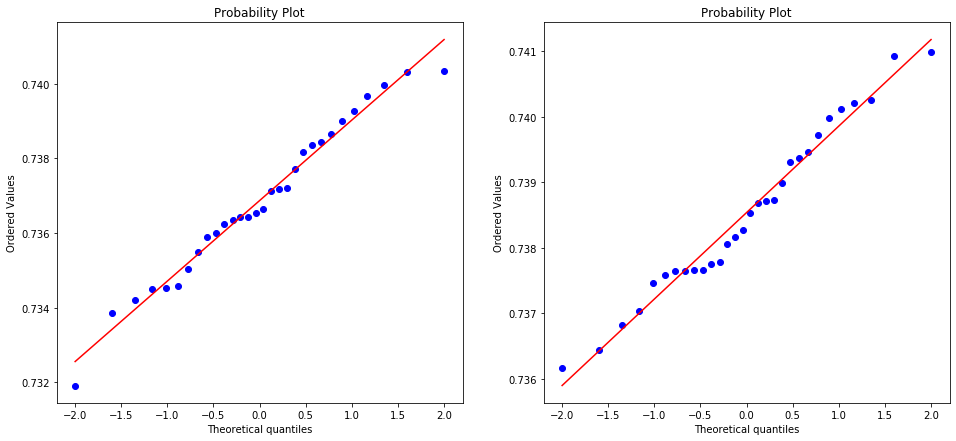

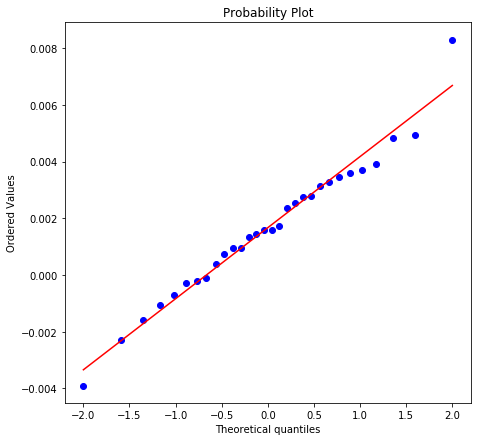

Тест Шапиро-Уилка для модели без гиперпараметров p-value=0.729164719581604
Тест Шапиро-Уилка для модели с гиперпараметрами p-value=0.5526574850082397



In [49]:
# построение куку графиков
plt.figure(figsize=(16,7))
plt.subplot(121)
scipy.stats.probplot(np.array(ctb_outofbox_results), dist="norm", plot=plt)


plt.subplot(122)
scipy.stats.probplot(np.array(ctb_model_results), dist="norm", plot=plt)
plt.show()


# разница значений
plt.figure(figsize=(16,7))
plt.subplot(121)
scipy.stats.probplot(np.array(ctb_model_results)-np.array(ctb_outofbox_results), dist="norm", plot=plt)
plt.show()


# значения критерия шапиро-Уилка
print('Тест Шапиро-Уилка для модели без гиперпараметров p-value={}\n'
     'Тест Шапиро-Уилка для модели с гиперпараметрами p-value={}\n'.format(stats.shapiro(np.array(ctb_outofbox_results))[1],
                                                                          stats.shapiro(np.array(ctb_model_results))[1]))

### Вывод

Тест Шапиро-Уилка не отвергает гипотезу о нормальности оценок. Визуально это также заметно.

Соотвественно, можно применить т-тест Стьюдента для того, чтобы понять отличаются ли значительно средние значения двух моделей.


- Оценим средние значения оценок двух моделей при помощи т-теста.

In [50]:
#оценим доверительный интервал разности
from statsmodels.stats.weightstats import *


# т-тест 
print("t-тест Стюдента: ",stats.ttest_rel(np.array(ctb_outofbox_results), np.array(ctb_model_results)))

#доверительный интервал разности
print("95%% доверительный интервал: [%f, %f]" % DescrStatsW(np.array(ctb_model_results) - np.array(ctb_outofbox_results)).tconfint_mean())


t-тест Стюдента:  Ttest_relResult(statistic=-3.7319834753138896, pvalue=0.0008239796142335104)
95% доверительный интервал: [0.000754, 0.002584]


### Вывод

Значение p_value < 0.05 => среднее значение оценок двух групп не одинакова.
При этом доверительный интервал для разности оценок двух моделей находится правее нуля. Это говорит о том, что средние результаты оценок модели с гиперпараметрами немного выше, чем у модели без гиперпараметров.

Теперь можем построить оценки доверительных интервалов долей


- Оценки доверительных интервалов долей

In [51]:
proportion_data = np.vstack((np.array(ctb_outofbox_results), np.array(ctb_model_results))) # соединяем по вертикали оценки для обеих моделей
proportion_data = pd.DataFrame(proportion_data).T # переводим в датасет и транспонируем 
proportion_data = proportion_data.rename(columns={0:'out_of_box_results', 1:'with_hyper_results'}) # изменяем имя столбцов
proportion_data['out_of_box_win'] = np.where(proportion_data['out_of_box_results']>proportion_data['with_hyper_results'], 1, 0) # проставляем значения 1, там где значения из коробки выше, чем у модели с параметрами
proportion_data['with_hyper_win'] = np.where(proportion_data['with_hyper_results']>proportion_data['out_of_box_results'], 1, 0) # # проставляем значения 1, там где значения у модели с параметрами выше, чем у модели из коробки

proportion_data.head(5)

,out_of_box_results,with_hyper_results,out_of_box_win,with_hyper_win
0,0.734507,0.737651,0,1
1,0.738445,0.737746,1,0
2,0.740321,0.740112,1,0
3,0.737187,0.739980,0,1
4,0.736430,0.738172,0,1


In [52]:
proportion_data[['out_of_box_win', 'with_hyper_win']].describe()

,out_of_box_win,with_hyper_win
count,30.000000,30.000000
mean,0.266667,0.733333
std,0.449776,0.449776
min,0.000000,0.000000
25%,0.000000,0.250000
50%,0.000000,1.000000
75%,0.750000,1.000000
max,1.000000,1.000000


In [53]:
from statsmodels.stats.proportion import proportion_confint

model_out_of_box = proportion_confint(sum(proportion_data['out_of_box_win']), 
                                      np.array(ctb_outofbox_results).shape[0],
                                      method = 'normal')
model_hyper = proportion_confint(sum(proportion_data['with_hyper_win']),
                                 np.array(ctb_model_results).shape[0],
                                 method = 'normal')


print('Доверительный интервал модели без гиперпараметров [%f, %f]' % model_out_of_box)
print('Доверительный интервал  интервал модели с гиперпараметрами [%f, %f]' % model_hyper)

Доверительный интервал модели без гиперпараметров [0.108424, 0.424909]
Доверительный интервал  интервал модели с гиперпараметрами [0.575091, 0.891576]


### Вывод

Значения интервалов для двух долей пересекаются. Значения для модели с гиперпараметрами находятся правее, что говорит о том, что значения оценки модели с гиперпараметрами выше, чем у модели без гиперпараметров. 

Посмотрим значения доверительного интервала для разности 2х долей (зависимые выборки)


- Значения доверительного интервала для разности 2х долей (зависимые выборки)

In [54]:
# напишем функцию значения доверительного интервала для разности 2х долей (зависимые выборки)

def proportions_confint_diff_rel(sample1, sample2, alpha = 0.05):
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    sample = list(zip(sample1, sample2))
    n = len(sample)
        
    f = sum([1 if (x[0] == 1 and x[1] == 0) else 0 for x in sample])
    g = sum([1 if (x[0] == 0 and x[1] == 1) else 0 for x in sample])
    
    left_boundary = float(f - g) / n  - z * np.sqrt(float((f + g)) / n**2 - float((f - g)**2) / n**3)
    right_boundary = float(f - g) / n  + z * np.sqrt(float((f + g)) / n**2 - float((f - g)**2) / n**3)
    return (left_boundary, right_boundary)

In [55]:
proportions_confint_diff_rel(proportion_data['out_of_box_win'],proportion_data['with_hyper_win'])

(-0.7831512347632548, -0.15018209857007864)

### Вывод

Значение доверительного интервала для разности 2х долей (зависимые выборки) содержит в себе 0.
Это говорит о том, что значения модели с гиперпараметрами немного лучше, чем значения модели без параметров, что также подтверждал предыдущий тест.


### Общий вывод

Поскольку значения оценки моделей соответствуют нормальному распределению (что подтвердил тест шапиро-Уилка), то для оценки результатов, которые дают нам модели, мы использовали параметрические критерии. Получились следующие результаты:

1. Распределение результатов оценок - нормальное
2. Т-тест показал, что значения средних в друх моделях отличаются. В моделе с гиперпараметрами значение среднего выше.
3. Значения для модели с гиперпараметрами находятся правее, что говорит о том, что значения оценки модели с гиперпараметрами выше, чем у модели без гиперпараметров.
4. Значение доверительного интервала для разности 2х долей (зависимые выборки) содержит в себе 0. Это говорит о том, что значения модели с гиперпараметрами немного лучше, чем значения модели без параметров.

Итог: результаты тестов показывают, что лучше в дальнейшем использовать Catboost с гиперпараметрами


## Этап 7: Оценка модели с точки зрения экономического эффекта

Построим кривые прироста концентрации и количества метки целевого класса в зависимости от взятого объёма выборки.

- test_data - тестовый датасет
- test_labels - тестовые метки
- cat_cols_selected - выбранные категориальные признаки
- num_cols_selected - выбранные числовые признаки

In [59]:
# построение графиков
import scikitplot as skplt

#возвращенные вероятности меток классификатором
y_probas = ctb_model.predict_proba(X_test_drop) 
y_probas

array([[0.96188473, 0.03811527],
       [0.94477792, 0.05522208],
       [0.97761219, 0.02238781],
       ...,
       [0.96482284, 0.03517716],
       [0.94741127, 0.05258873],
       [0.97581064, 0.02418936]])

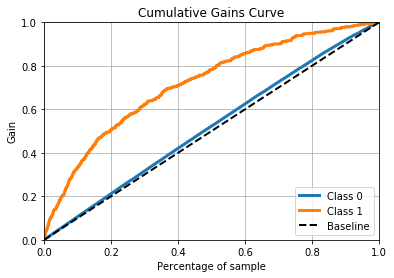

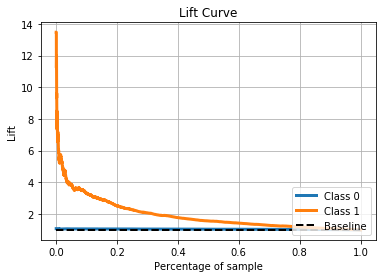

In [60]:
# график отображающий динамику изменения целевых меток при увеличении объема выборки
skplt.metrics.plot_cumulative_gain(test_labels, y_probas)
plt.show()

# график отображающий разницу классов в соответствии с увеличеним объема выборки
skplt.metrics.plot_lift_curve(test_labels, y_probas)
plt.show()

### Вывод

1. График "Cumulative Gains Curve" отображает по оси "x" объем выборки в %, по оси "y" количество меток целевого класса при данном объеме выборки. 
2. Графике "Lift Curve" по оси "x" отображает объем выборки в %, по оси "y" то, во сколько раз при данном объеме выборки меток целевого класса больше согласно ранжированию классификатора, чем при случайном отборе такого же объёма выборки.

Проблематично посчитать экономический эффект от внедрения данной модели без наличия каких-то данных.
Поэтому для расчета экономического эффекта возьмем данные из сферы телекомунникационных компаний.



1. Вот здесь можно взять информацию по размеру доли дохода Мегафона от мобильной связи (https://www.cnews.ru/news/top/2020-04-08_mtsbilajn_i_megafon):


"Выручка «Мегафона» по всем регионам присутствия составила 348,9 млрд руб. Выручка от услуг мобильной связи составила 280,4 млрд , из этой суммы 107,6 млрд руб. приходится на услуги мобильной передачи данных. Показатель OIBDA составил 151,6 млрд руб., рентабельность по данному показателю – 43,4%."

Отсюда: *% выручки от услуг сотовой связи, предоставляемых абоненту* = 280,4 млрд/348,9 млрд руб = *80%*

2. Взглянем на один из главных операционных показателей — ARPU (Average Revenue per User) средняя выручка на одного абонента.

ARPU = 376 руб

Подробнее на БКС Экспресс:
https://bcs-express.ru/novosti-i-analitika/komu-iz-operatorov-sotovoi-sviazi-klienty-platiat-bol-she-vsego

3. Пусть среднее время нахождения человека у одного оператора = 5 лет.

Предложение для удержания клиента: 
Предоставление скидки в размере 30% на услуги сотовой связи на 2 года.
Стоимость такой компании = 1 СМС до клиента стоимостью 1 рубль.

Предположим, что 60% людей примут данное предложение.


- У нас есть test_labels - метки классов, где  1 - отток, 0 - не отток. 
Установим некоторые параметры для расчета экономического эффекта. 

#### Дано:

In [61]:
#всего клиентов, склонных к оттоку
total_churn = test_labels.sum()[0]

#всего лояльных клиентов в выборке
total_overall = len(test_labels)-total_churn

# ARPU (Average Revenue per User) средняя выручка на одного абонента.
arpu = 376

# cреднее время нахождения человека у одного оператора (в месяцах)
average_time = 5 * 12

# % выручки от услуг сотовой связи, предоставляемых аббоненту (себестоимость)
self_cost = 0.8

# lifetime value от клиента в среднем
ltv = arpu * average_time * self_cost

#вероятность приниятия предложения
prob_return = 0.6



print('Клиентов всего =',total_overall)
print('Количество клиентов склонных к оттоку =',total_churn)
print('ARPU =',arpu)
print('cреднее время нахождения человека у одного оператора (в месяцах) =',average_time)
print('Себестоимость =',self_cost)
print('lifetime value =',ltv)
print('Вероятность приниятия предложения =', prob_return)


Клиентов всего = 7406
Количество клиентов склонных к оттоку = 594
ARPU = 376
cреднее время нахождения человека у одного оператора (в месяцах) = 60
Себестоимость = 0.8
lifetime value = 18048.0
Вероятность приниятия предложения = 0.6


Предположим, что у нас есть значения порога для определения реального количества уходящих клиентов и ошибочно определенных к оттоку клиентов 

In [62]:
# порог определения значений оттока/не оттока
thresh_churn = 0.8
thresh_overall = 0.5


#среднее количество реально уходящих клиентов от уровня порога
churn_rate = total_churn * thresh_churn

#количество неверно определенных к оттоку клиентов от уровня порога
overall_rate = total_overall * thresh_overall

#скидка за связь
discount = 0.3

#стоимость удержания одного клиента
total_cost = arpu * discount * 12 + 1


print('Среднее количество реально уходящих клиентов от уровня порога =',churn_rate)
print('Количество неверно определенных к оттоку клиентов от уровня порога =',overall_rate)
print('Скидка за связь =',discount)
print('Стоимость удержания одного клиента =', total_cost)

Среднее количество реально уходящих клиентов от уровня порога = 475.20000000000005
Количество неверно определенных к оттоку клиентов от уровня порога = 3703.0
Скидка за связь = 0.3
Стоимость удержания одного клиента = 1354.6


In [63]:
#посмотрим на выручку в зависимости от порога

actual = np.ravel(test_labels.values) # целевые метки из тестовой выборки
predicted = ctb_model.predict_proba(X_test_drop)[:, 1] # предсказанная вероятность нашей модели
data = zip(actual, predicted) # соединяем датасет целевых меток и предсказанных вероятностей

sorted_data = sorted(data, key=lambda d: d[1], reverse=True) # сортировка датасета по убыванию вероятности
sorted_actual = [d[0] for d in sorted_data] # сортированный датасет действущих целевых меток
cumulative_actual = np.cumsum(sorted_actual) / sum(actual) # накапливая сумма / на сумму действующих меток
cumulative_index = np.arange(1, len(cumulative_actual)+1) / len(predicted) 

In [73]:
cumulative_index

array([1.25000e-04, 2.50000e-04, 3.75000e-04, ..., 9.99750e-01,
       9.99875e-01, 1.00000e+00])

In [80]:
#функция возвращающая лучшее значение выручки и пороги при нём
def calc_max(t_churn, t_overall):
    max_profit = 0 # размер максимальной прибыли
    params = [] # параметры
    
    for i in range(len(t_churn)):
    # прибыль =  (lifetime value * (Количество клиентов склонных к оттоку * камуликативная сумма * вероятность возврата)) - (Стоимость удержания одного клиента * камуликативный индекс )
        profit = (ltv * (total_churn * t_churn[i] * prob_return)) - (total_cost * (total_overall * t_overall[i]))
        
        if profit >= max_profit:
            params.clear()
            max_profit = profit
            params = [t_churn[i], t_overall[i]] # список параметров 
    return [max_profit, params]

In [82]:
results = calc_max(cumulative_actual, cumulative_index)
results

[1365927.5460000003, [0.4696969696969697, 0.165]]

In [77]:

print('Если при проведении кампании по удержанию алгоритм применяется на 8 тысяч человек, наибольший эффект\n'
     'будет достигнут при выборе первых {} % выборки после ранжирования в которых будет {} человека склонных к оттоку\n'
     'из {} человек склонных к оттоку в исходной выборке и экономический эффект от данной кампании составит {} рублей'.format(((round(results[1][1] * 100, 3))),
     int(round((total_churn * results[1][0]), 1)), total_churn, int(round(results[0], 1))))

Если при проведении кампании по удержанию алгоритм применяется на 8 тысяч человек, наибольший эффект
будет достигнут при выборе первых 16.5 % выборки после ранжирования в которых будет 279 человека склонных к оттоку
из 594 человек склонных к оттоку в исходной выборке и экономический эффект от данной кампании составит 1365927 рублей


In [78]:
#построим график зависимости порога выборки от полученных денег
profit = []
churn_portion = []
overall_portion = []
for i in range(len(cumulative_actual)):
    money = (ltv * (total_churn * cumulative_actual[i] * prob_return)) - (total_cost * (total_overall * cumulative_index[i]))
    profit.append(money)
    churn_portion.append(cumulative_actual[i])
    overall_portion.append(cumulative_index[i])

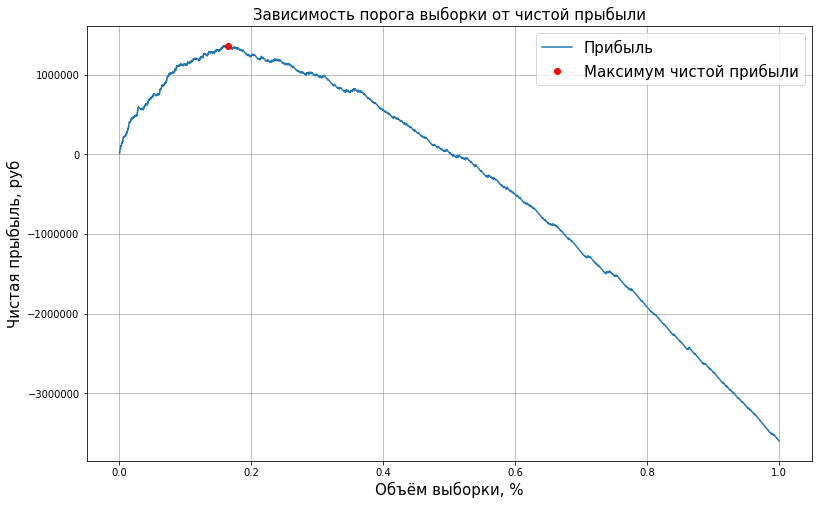

In [79]:
#отрисовка графика
fig, ax = plt.subplots(figsize=(13, 8))
ax.plot(overall_portion, profit, label='Прибыль')
ax.set_xlabel('Объём выборки, %', fontsize=15)
ax.set_ylabel('Чистая прыбыль, руб', fontsize=15)

ax.plot(results[1][1], results[0], 'o', color='r', label='Максимум чистой прибыли')
ax.grid()
ax.legend(fontsize=15)
plt.title('Зависимость порога выборки от чистой прыбыли', fontsize=15)
plt.show()

### Общий вывод

Очень сложно расценивать данные экономический эффект, поскольку данные являются примерными и взяты из открытых источников. Также сама методика оценки экономического эффекта является идеей автора и , вероятно, в реальных кейсах используются другие способы оценки экономической эффективности в подобных задачах. Несмотря на это можно сделать следующие выводы:

1. По графику рост чистой прибыли наблюдается до 18% объема выборки, затем наблюдается ее снижение.

2. График показывает, что применение модели невсегда экономически оправдано. Нужно учитывать такие факторы как: прибыль с клиента, себестоимость услуг, вероятность принятия предложения клиентом, пороговые значения и т.д.

3. Поскольку в подобных задачах данные постоянно меняются, то необходимо постоянно производить переобучение алгоритма и дорабатывать модель. Также следует использовать А/Б тестирование для проверки того, насколько кампания по удержанию клиентов работает эффективно. 




## Этап 8: Возможности улучшения алгоритма

In [84]:
# возьмем все наши обработанные данные

df = pd.concat((train_x_drop,X_test_drop)) # датасет
y = pd.concat((train_labels, test_labels)) # целевые метки

In [88]:
from sklearn.model_selection import learning_curve

# Генератор перекрестной проверки, который разделяет весь набор данных k раз на обучающие и тестовые данные. 
# Подмножества обучающего набора с различными размерами будут использоваться для обучения и оценки для каждого размера обучающего подмножества
# После этого оценки будут усреднены по всем k запускам для каждого размера обучающей подгруппы.

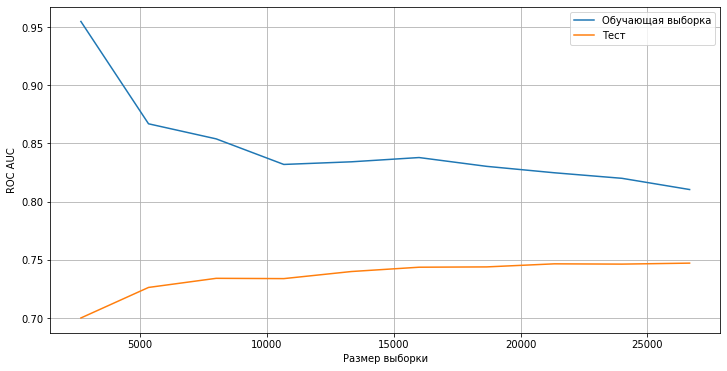

In [87]:
#посмотрим как объём выборки влияет на качество, возможно необходимо увеличить количество данных для обучения
train_sizes, train_scores, test_scores = learning_curve(ctb_model, df, y, cv=StratifiedKFold(), scoring='roc_auc',
                                                       train_sizes=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])


plt.figure(figsize=(12,6))
plt.plot(train_sizes, train_scores.mean(axis=1), label=u"Обучающая выборка")
plt.plot(train_sizes, test_scores.mean(axis=1), label=u"Тест")

plt.xlabel(u'Размер выборки')
plt.ylabel(u'ROC AUC')
plt.legend(loc="best")
plt.grid()
plt.show()


Как видно из графика, метрика на тестовой выборке вместе с увеличением обучающей выбокри перестает расти. Поэтому в данном случае увеличения объема выборки не бдует способствовать росту качества модели.

### Общий вывод

Повышения качества алгоритма можно добиться за счет следующих действий:

1. Деаномизация признаков. Изначально признаки в датасете были без какого-либо описания, что усложнило задачу построения алгоритма. Описание признаков позволило бы повысить качсетво модели.
2. Обработать датасет в соотвествии с описание признаков. В датасете бьло очень много пропущенных значений, который обрабатывались мной "в лоб". Возможно, в этих пропусках есть смысл и если бы была информация об этом, то это позволило бы обработать их более грамотно и повысить качсетво модели. 
3. Как вариант, использовать более сложные модели.


## Заключение

Были проанализированы данные компании Orange и составлена вероятностная модель прогнозирования оттока клиентов. Модель использует исходные числовые данные, а такжекатегориальных признаки, переведенные в числовые. Для построения использовалась модель Catboost. Сделана оценка качества модели. Проведен расчет экономической эффективности модели, показаны условия, когда она может быть прибыльной, а так же высказаны идеи и предположения об ее внедрении и эксплуатации.